**Kullanılan veri seti müşteri kaybı tahmini ile ilgili.
Veri seti Müşteri bilgilerini içeriyor ve bu bilgileri kullanarak bir müşterinin bankadan ayrılıp ayrılmayacağını tahmin etmeye çalışıyor.**

In [1]:
# Veri Yükleme
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("Churn_Modelling.csv")
print(data.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [2]:
# Aykırı değerleri IQR yöntemiyle tespit etme ve Temizleme
numeric_features = ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'Tenure', 'NumOfProducts']
numeric_data = data[numeric_features]
Q1 = numeric_data.quantile(0.25) # Verinin %25 i
Q3 = numeric_data.quantile(0.75) # Verinin kalan %75'lik kısmı
IQR = Q3 - Q1 # IQR, verinin ortadaki %50'lik kısmının yayılımını ölçer.
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1) # Aykırı değerleri belirleyen formül
data_no_outliers = data[~outliers] # Aykırı olmayan satırlar
print(data_no_outliers.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

Not: Label Encoding yerine neden One-Hot Encoding kullandım? Çünkü Label Encoding daha çok Sıralı(Ordinal) kategorileri için uygun iken One-Hot Encoding Sırasız(Nominal) kategoriler için daha güvenli bir yöntemdir. Benim kullandığım veri setinde Geography ve Gender kategorileri Nominal değişken olduklarından dolayı One-Hot Encoding yöntemini kullandım.

Not2: Neden MinMaxScaler değil de StandartScaler kullandım? Çünkü MinMaxScaler aykırı değerler karşı daha hassas bir yöntemdir zaten ben halihazırda aykırı değerleri temizledim ve ayrıca KNN, Logistik Regressyon gibi mesafe bazlı modellerle daha uyumlu

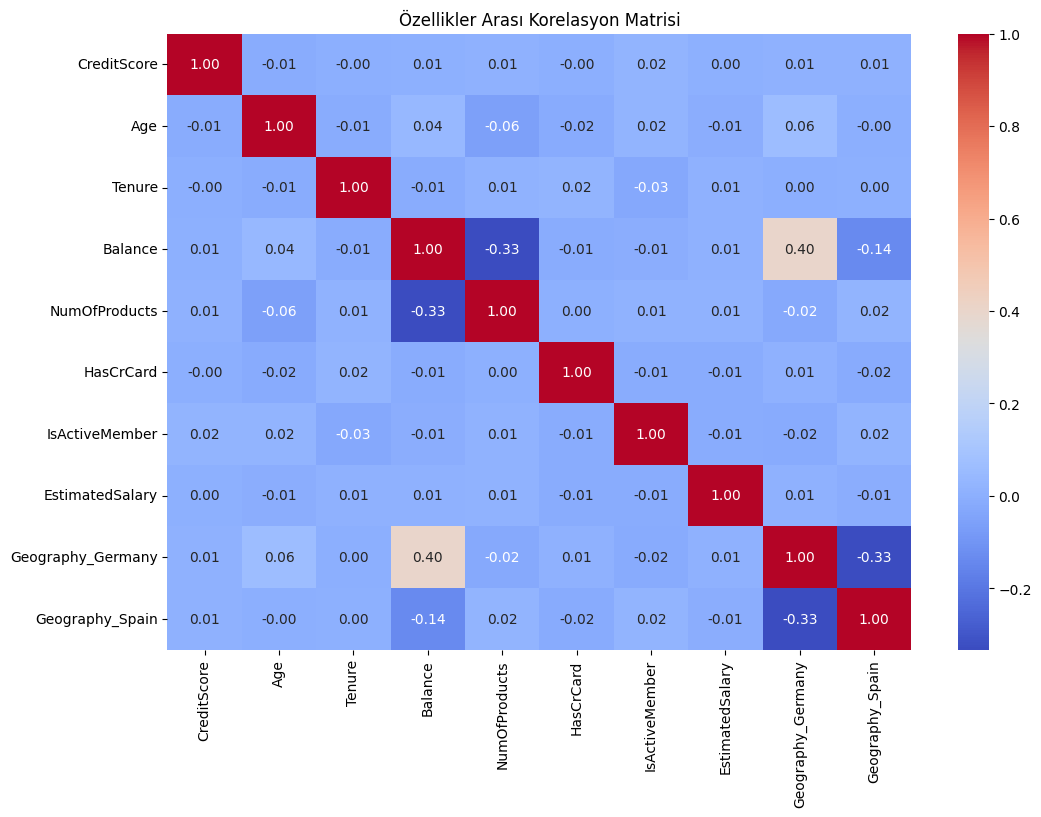

   CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0    -0.329808  0.485534 -1.044203 -1.224651      -0.938614   0.646616   
1    -0.444286  0.371671 -1.390497  0.118145      -0.938614  -1.546514   
2    -1.547436  0.485534  1.033562  1.333486       2.699489   0.646616   
3     0.502758  0.143947 -1.390497 -1.224651       0.880438  -1.546514   
4     2.074226  0.599396 -1.044203  0.786324      -0.938614   0.646616   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0        0.992711         0.021813       1          -0.578316        -0.574132  
1        0.992711         0.216419       0          -0.578316         1.741760  
2       -1.007343         0.240567       1          -0.578316        -0.574132  
3       -1.007343        -0.108963       0          -0.578316        -0.574132  
4        0.992711        -0.365266       0          -0.578316         1.741760  


In [3]:
# Kategorik değişkenleri One-Hot Encoding ile sayısal değerlere dönüştürme
data_no_outliers = pd.get_dummies(data_no_outliers, columns=['Geography', 'Gender'], drop_first=True)

# Gereksiz sütunları kaldırma
data_no_outliers = data_no_outliers.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Eksik dataleri silme
data_no_outliers = data_no_outliers.dropna()

# Normalizasyon işlemi
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_outliers.iloc[:, :-1])

# Normalizasyon sonrası data setini DataFrame'e dönüştürme
data_normalized = pd.DataFrame(scaled_data, columns=data_no_outliers.columns[:-1])

# Hedef sütunu yeniden ekleme
data_normalized['Exited'] = data_no_outliers['Exited'].reset_index(drop=True)

# NaN kontrolü ve temizliği
data_normalized = data_normalized.dropna()

# Sadece özelliklerin korelasyonuna bakmak istiyoruz (hedef hariç)
correlation_matrix = data_normalized.drop(columns=['Exited']).corr()

# Korelasyon matrisini gösterme
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()

print(data_normalized.head())


In [4]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

X = data_normalized.drop(columns=['Exited'])
y = data_normalized['Exited']

# 1. SelectKBest (ANOVA F-test)
skb = SelectKBest(score_func=f_classif, k=8)
X_skb = skb.fit_transform(X, y)
skb_features = X.columns[skb.get_support()]

# 2. RFE (Logistic Regression)
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=8)
X_rfe = rfe.fit_transform(X, y)
rfe_features = X.columns[rfe.get_support()]

# 3. Tree-based Feature Importance
model_tree = ExtraTreesClassifier()
model_tree.fit(X, y)
importances = model_tree.feature_importances_
tree_features = X.columns[importances.argsort()[-8:]]

print("SelectKBest Özellikleri:", list(skb_features))
print("RFE Özellikleri:", list(rfe_features))
print("Tree-Based Özellikleri:", list(tree_features))


SelectKBest Özellikleri: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_Germany', 'Geography_Spain']
RFE Özellikleri: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany']
Tree-Based Özellikleri: ['Geography_Germany', 'IsActiveMember', 'Tenure', 'NumOfProducts', 'CreditScore', 'Balance', 'EstimatedSalary', 'Age']


In [5]:
# Fonksiyon tanımı: Modeli eğitma, tahmin etme ve metrikleri yazdırma
def evaluate_model(X, y, model, name=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} için sonuçlar:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Model tanımları
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVC RBF": SVC(kernel='rbf', C=1, gamma='scale', probability=True)
}

# Her model için her özellik seçimi setiyle test et
feature_sets = {
    "SelectKBest": skb_features,
    "RFE": rfe_features,
    "TreeBased": tree_features
}

for model_name, model in models.items():
    for fs_name, features in feature_sets.items():
        evaluate_model(X[features], y, model, f"{model_name} + {fs_name}")



KNN + SelectKBest için sonuçlar:
Confusion Matrix:
 [[2166  130]
 [ 309  266]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2296
           1       0.67      0.46      0.55       575

    accuracy                           0.85      2871
   macro avg       0.77      0.70      0.73      2871
weighted avg       0.83      0.85      0.84      2871


KNN + RFE için sonuçlar:
Confusion Matrix:
 [[2161  135]
 [ 326  249]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      2296
           1       0.65      0.43      0.52       575

    accuracy                           0.84      2871
   macro avg       0.76      0.69      0.71      2871
weighted avg       0.82      0.84      0.83      2871


KNN + TreeBased için sonuçlar:
Confusion Matrix:
 [[2161  135]
 [ 326  249]]
Classification Report:
               precision    recall  f1-score 

In [7]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

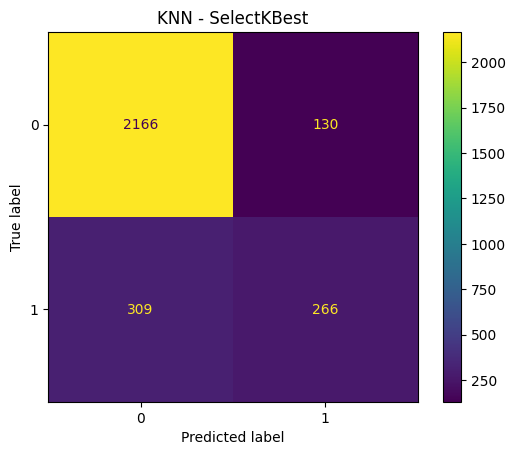

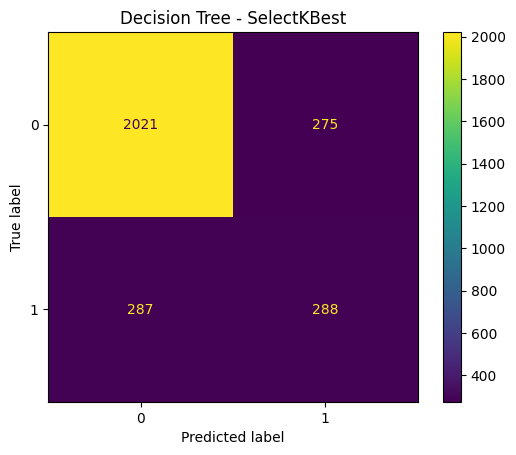

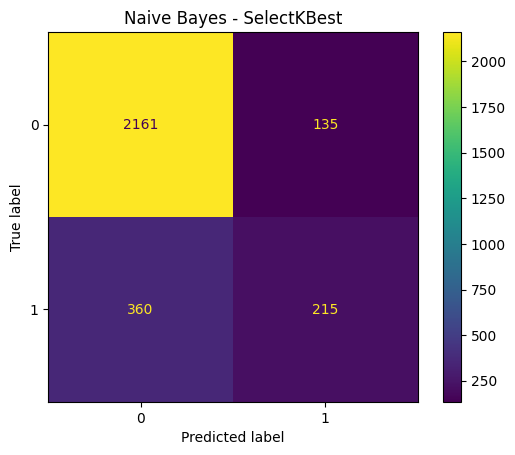

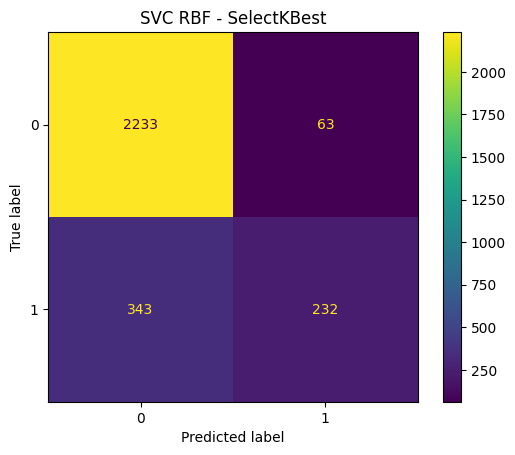

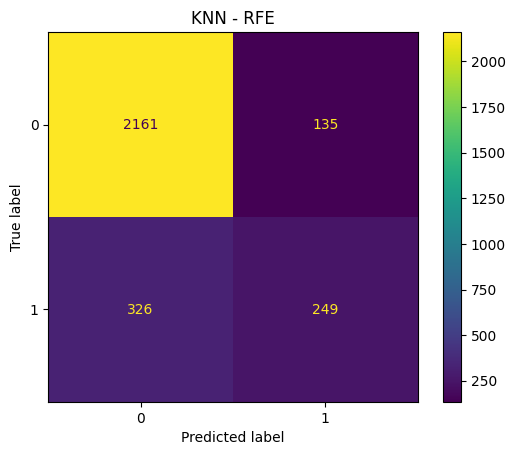

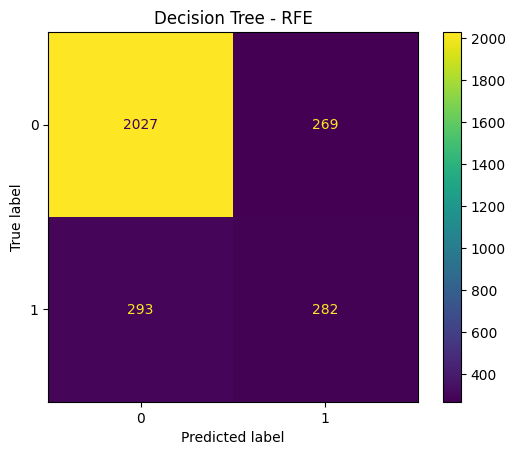

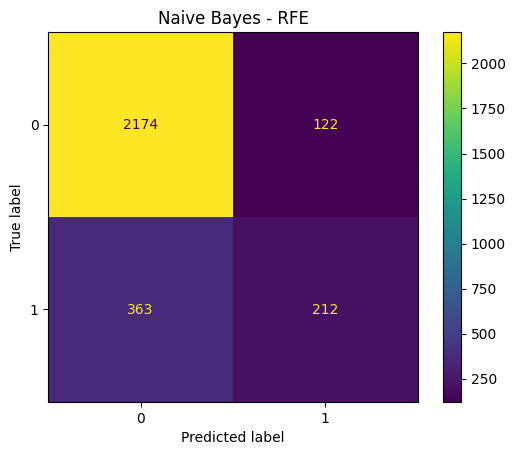

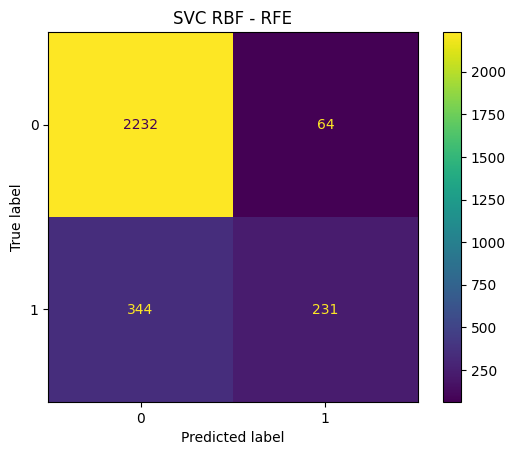

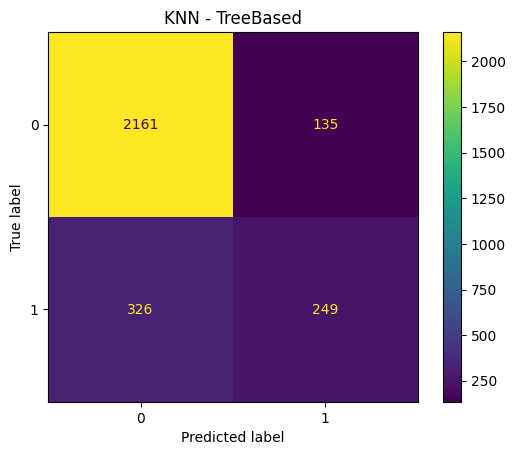

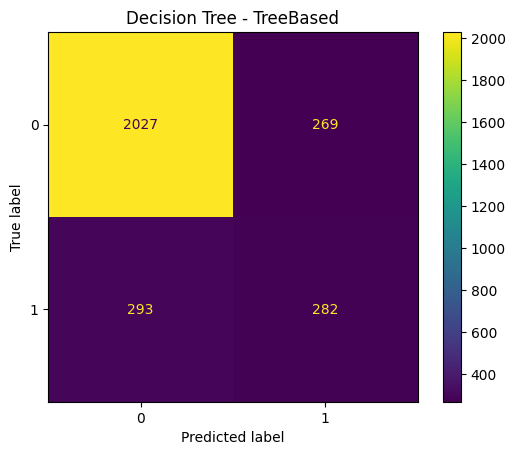

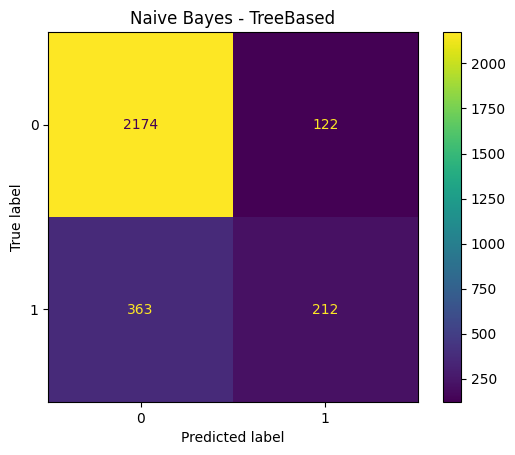

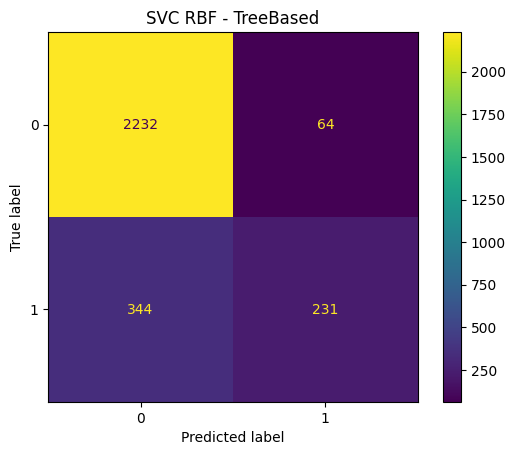

In [8]:
results = []
for fs_name, features in feature_sets.items():
    for model_name, model in models.items():
        X_fs = X[features]
        X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.3, random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': model_name,
            'FeatureSelection': fs_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1
        })

        # Karışıklık Matrisi
        plot_conf_matrix(y_test, y_pred, f"{model_name} - {fs_name}")


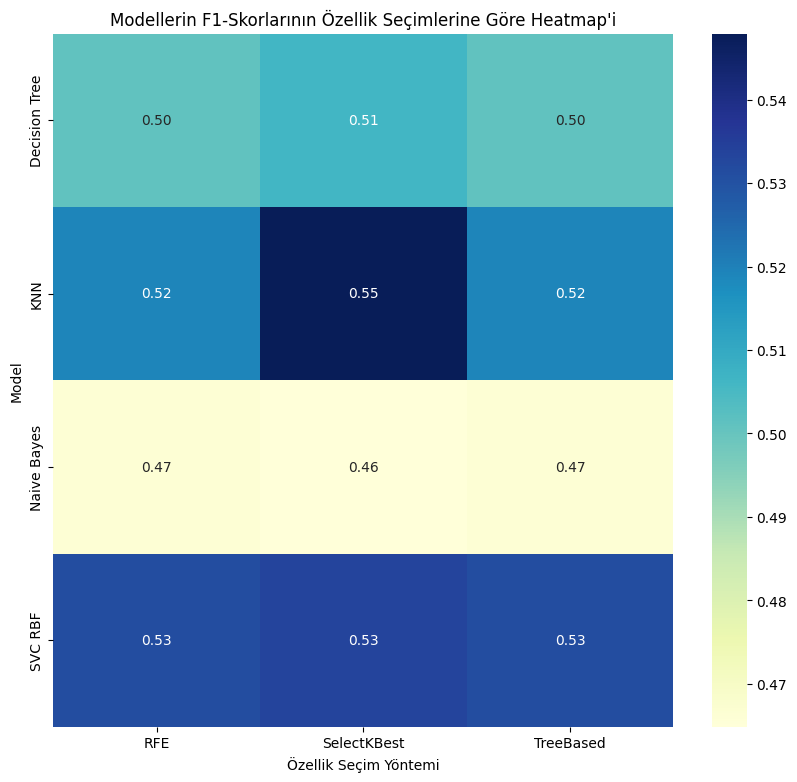

In [9]:
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot(index='Model', columns='FeatureSelection', values='F1')

# Heatmap çizimi
plt.figure(figsize=(10, 9))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Modellerin F1-Skorlarının Özellik Seçimlerine Göre Heatmap'i")
plt.ylabel("Model")
plt.xlabel("Özellik Seçim Yöntemi")
plt.show()




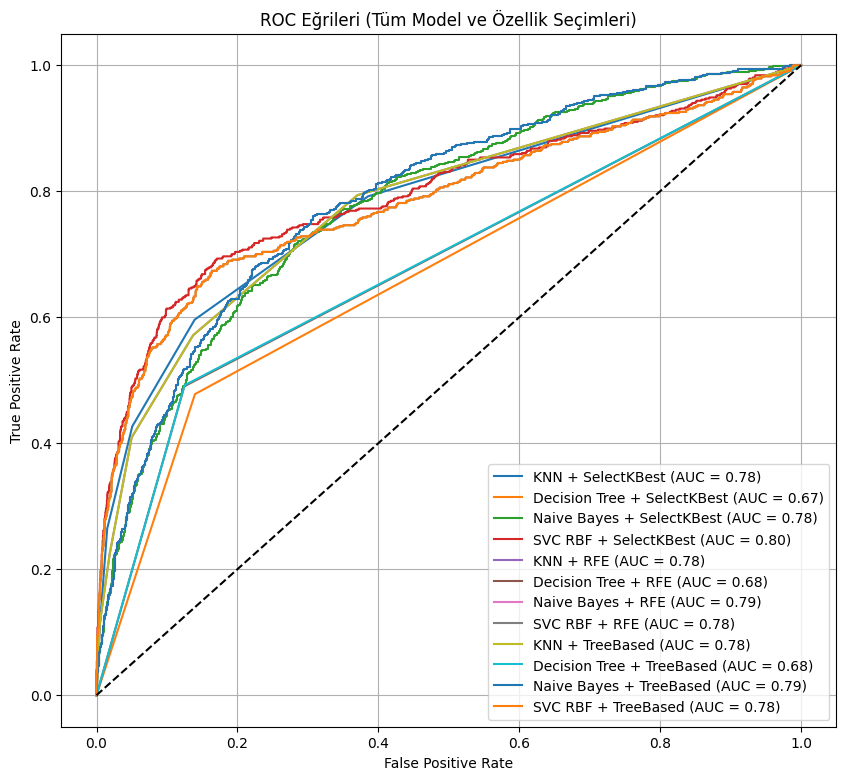

In [10]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 9))

for fs_name, features in feature_sets.items():
    for model_name, model in models.items():
        X_fs = X[features]
        X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.3, random_state=42, stratify=y)

        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        label = f"{model_name} + {fs_name} (AUC = {roc_auc:.2f})"
        plt.plot(fpr, tpr, label=label)

# ROC çizimi
# Her eğri, bir modelin farklı eşik (threshold) değerlerinde nasıl performans gösterdiğini ifade eder.
# TPR (Y dikeyi): Gerçek pozitifleri bulma oranı (Recall olarak da bilinir).
# FPR (X yatayı): Gerçekte negatif olanları yanlış pozitif olarak tahmin etme oranı.

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri (Tüm Model ve Özellik Seçimleri)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
import pickle
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Modeli yükle
with open('best_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Giriş widget'ları
credit_score = widgets.FloatText(description="CreditScore:")
geography = widgets.Dropdown(options=['France', 'Spain', 'Germany'], description="Geography:")
gender = widgets.Dropdown(options=['Male', 'Female'], description="Gender:")
age = widgets.IntText(description="Age:")
tenure = widgets.IntText(description="Tenure:")
balance = widgets.FloatText(description="Balance:")
num_of_products = widgets.IntText(description="Products:")
has_cr_card = widgets.Dropdown(options=[0, 1], description="HasCard:")
is_active = widgets.Dropdown(options=[0, 1], description="Active:")
salary = widgets.FloatText(description="Salary:")
submit_btn = widgets.Button(description="Tahmin Et")

# Encoding
def encode_input():
    # One-hot encoding for Geography
    geo_france = 1 if geography.value == 'France' else 0
    geo_germany = 1 if geography.value == 'Germany' else 0

    # Gender: Male=1, Female=0
    gen = 1 if gender.value == 'Male' else 0

    return np.array([[
        credit_score.value,
        geo_france,
        geo_germany,
        gen,
        age.value,
        tenure.value,
        balance.value,
        num_of_products.value,
        has_cr_card.value,
        is_active.value,
        salary.value
    ]])

# Tahmin fonksiyonu
def on_submit_clicked(b):
    input_data = encode_input()

    # Modelin eğitildiği 8 özelliğin index'lerini buraya gir
    selected_feature_indices = [0, 2, 3, 4, 6, 7, 9, 10]  # <- örnek: güncellemen gerekebilir

    input_data_selected = input_data[:, selected_feature_indices]

    prediction = model.predict(input_data_selected)[0]
    prob = model.predict_proba(input_data_selected)[0]
    print("Tahmin (Exited):", prediction)
    print("Olasılıklar [Kalmadı, Çıktı]:", prob)


submit_btn.on_click(on_submit_clicked)

# Widgetları göster
display(credit_score, geography, gender, age, tenure, balance,
        num_of_products, has_cr_card, is_active, salary, submit_btn)


FloatText(value=0.0, description='CreditScore:')

Dropdown(description='Geography:', options=('France', 'Spain', 'Germany'), value='France')

Dropdown(description='Gender:', options=('Male', 'Female'), value='Male')

IntText(value=0, description='Age:')

IntText(value=0, description='Tenure:')

FloatText(value=0.0, description='Balance:')

IntText(value=0, description='Products:')

Dropdown(description='HasCard:', options=(0, 1), value=0)

Dropdown(description='Active:', options=(0, 1), value=0)

FloatText(value=0.0, description='Salary:')

Button(description='Tahmin Et', style=ButtonStyle())

IndexError: arrays used as indices must be of integer (or boolean) type

IndexError: arrays used as indices must be of integer (or boolean) type